In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True
dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)
# [2016, 2017, 2018]
# dataset = Para()
if type(dataset) != ParaMultipleDates:
	patchesHandler = PatchesHandler()
else:
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)

training = False
save_probabilities = True
loadInference = True
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		# exp = 69
		# exp = 70
		exp = 72
	if type(dataset) == MTDeforestationTime:
		exp = 28

else:
	exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 72

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [4]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [5]:
# ic(type(dataset), exp, dataset.dates)


In [6]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([0., 1.], dtype=float32), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
                                                                    2016., 2017., 2018., 2019., 2020., 2021.], dtype=float32),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [7]:
# np.save('label_not_independent.npy', label_mask)


In [8]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [9]:
label_mask.dtype

dtype('uint8')

In [10]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [11]:
label_mask.dtype

dtype('uint8')

In [12]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [13]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [14]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [15]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [16]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [17]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

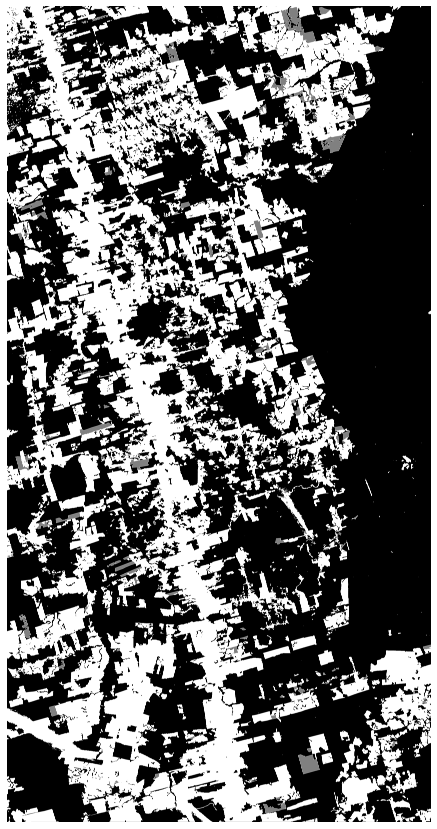

In [18]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [19]:
if training == True:
    print(coords_train)

In [20]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [21]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [22]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [23]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [24]:
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [25]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [26]:
if training == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [27]:
if training == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [28]:
if training == True:

    idx = 3000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [29]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [30]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [31]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [32]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [33]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/exp72'

In [34]:
channels

21

In [35]:
image_stack.shape

(17730, 9200, 21)

In [36]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [37]:
image_stack.shape

(17730, 9200, 21)

In [38]:
patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [39]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [40]:
image_stack.shape

(17730, 9200, 21)

In [41]:
#%% Test loop
times = 10

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack


-30.0 -16.0


In [42]:


h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,times):
            print('time: ', tm)

            new_model = build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
                nb_filters = nb_filters, n_classes = class_n)

            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            
            
            # Recinstructing predicted map
            start_test = time.time()

            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp72/models/resunet_0.h5'


In [43]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [44]:
del image1_pad


In [45]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, times), dtype = np.float32)

    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)



0
1
2
3
4
5
6
7
8
9


In [46]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [47]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

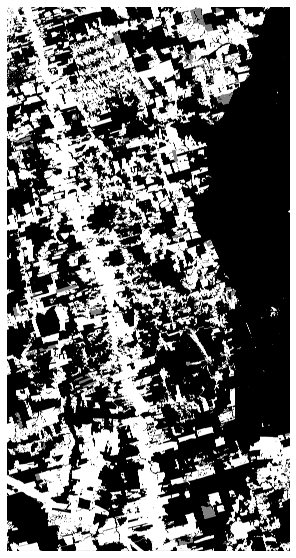

In [48]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

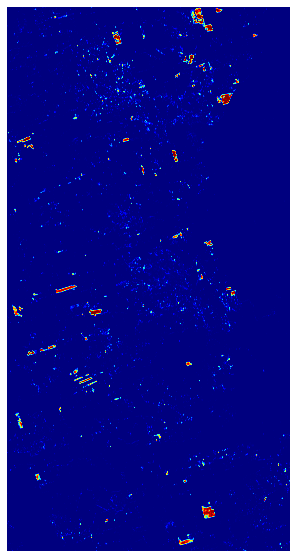

In [49]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [50]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [51]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54253101,)
(array([0, 1], dtype=uint8), array([53486282,   766819], dtype=int64))


In [52]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

88.64


In [53]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [54]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [55]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [56]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [175]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.011972547
    np.max(prob_rec): 1.0


(0.0, 0.011972547, 1.0)

In [173]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [174]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.009796464
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 9.741014e-23
    np.mean(pred_entropy): 0.010461689
    np.max(pred_entropy): 0.36787948


(9.741014e-23, 0.010461689, 0.36787948)

In [59]:
prob_rec.shape

(10, 17760, 9216, 1)

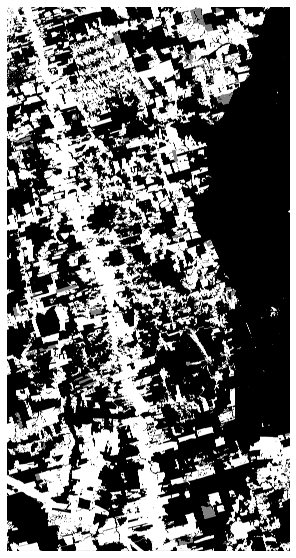

In [60]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [61]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

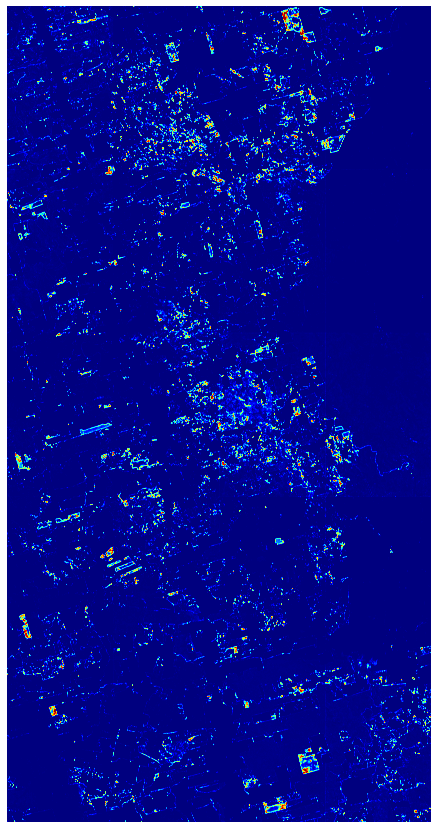

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [63]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

ic| np.min(pred_entropy_to_show): 9.741014e-23
    np.mean(pred_entropy_to_show): 0.010474452
    np.max(pred_entropy_to_show): 0.36787948


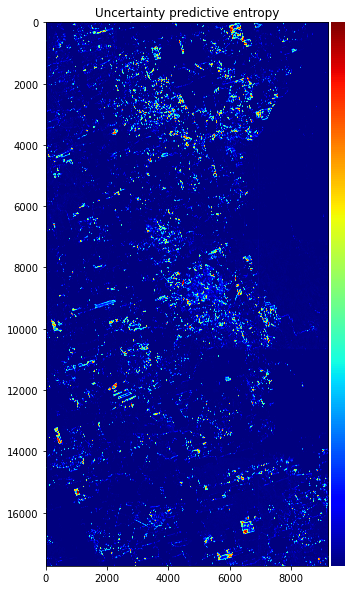

In [172]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [65]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 17760, 9216, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.011972547
    np.max(prob_rec): 1.0


(0.0, 0.011972547, 1.0)

In [66]:

'''
pred_entropy_single = single_experiment_entropy(prob_rec[0])

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\npred_entropy_single = single_experiment_entropy(prob_rec[0])\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [67]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


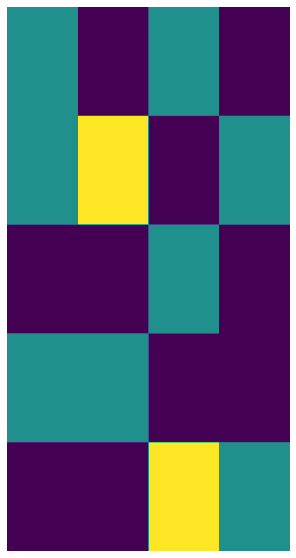

In [68]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [69]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [70]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1842066, 161273934], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1842066, 161273934], dtype=int64))

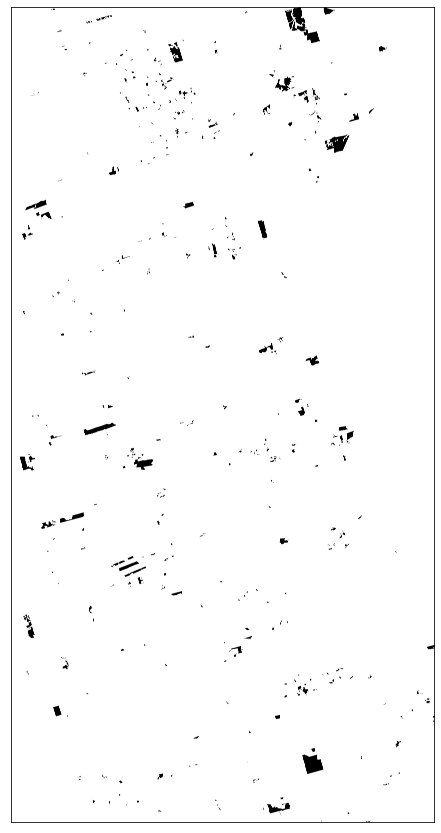

In [71]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [72]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9453222,)


(9453222,)

In [73]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [74]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.330721, F-Score=0.820


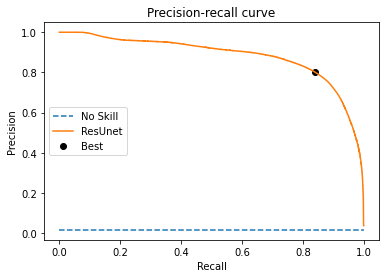

In [75]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [76]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
# threshold = 0.5
threshold = best_threshold
# threshold = 0.46
# threshold = 0.57
# threshold = 0.5624
# threshold = 0.43
# threshold = 0.33
# threshold = 0.41
# threshold = 0.414413
# threshold = 0.507776
# threshold = 0.5622921
# threshold = 0.516014
# threshold = 0.405565
# threshold = 0.348671
# threshold = 0.394683
# threshold = 0.541279
threshold = 0.420339

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


(array([0., 1.], dtype=float32), array([161492560,   1623440], dtype=int64))


In [77]:
threshold

0.420339

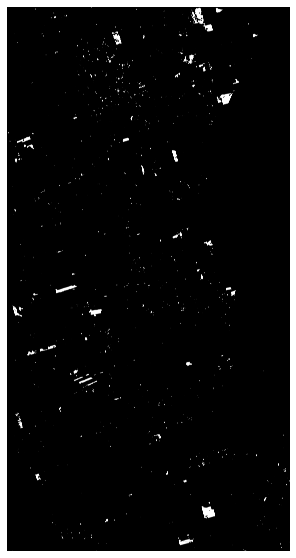

In [78]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [79]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [80]:
# mean_prob_unpad.shape

In [81]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [82]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [83]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [84]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [85]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [86]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)

        mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                mean_prob_test)*100, 2)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54253101,)
ic| f1: 81.36, precision: 87.15, recall: 76.29, mAP: 88.64


In [87]:
ic(f1, precision, recall, mAP)

ic| f1: 81.36, precision: 87.15, recall: 76.29, mAP: 88.64


(81.36, 87.15, 76.29, 88.64)

### Metrics for validation set in forest/deforestation detection

In [88]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [89]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [90]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 81.23
    precision_val: 84.02
    recall_val: 78.62
    mAP_val: 88.23


(81.23, 84.02, 78.62, 88.23)

In [91]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162422114,    693886], dtype=int64))


In [92]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   456256, 162422114,    237630], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   456256, 162422114,    237630], dtype=int64))

In [93]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [94]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

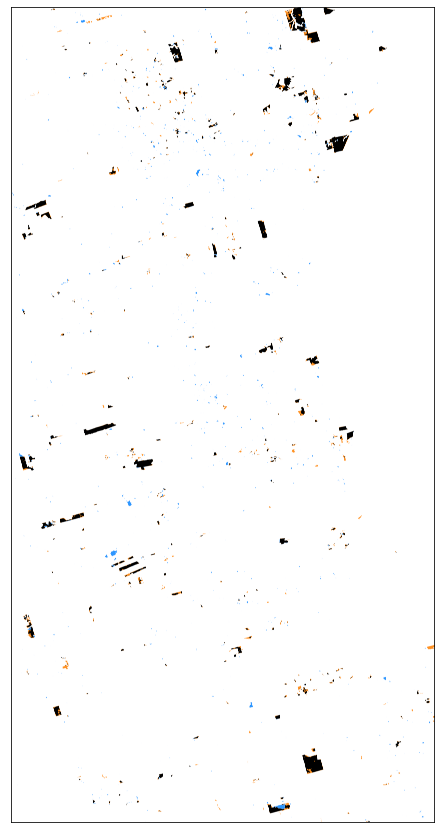

In [95]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


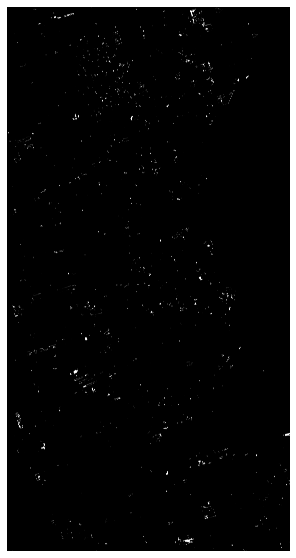

In [96]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [98]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54253101,)


(54253101,)

In [99]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [100]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  

ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [101]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [102]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    y_pred = pred_var_test
    y_pred_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    y_pred = MI_test
    y_pred_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    y_pred = pred_entropy_test
    y_pred_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    y_pred = pred_entropy_single_test
    y_pred_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [169]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(y_pred): 1.9414037e-18
    np.mean(y_pred): 0.012316057
    np.max(y_pred): 0.36787948
ic| np.min(pred_entropy): 9.741014e-23
    np.mean(pred_entropy): 0.010461689
    np.max(pred_entropy): 0.36787948


(9.741014e-23, 0.010461689, 0.36787948)

In [103]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, y_pred.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54253101,), y_pred.shape: (54253101,)
ic| roc_auc: 0.979275692386089


0.979275692386089

Best Threshold=0.031026, G-Mean=0.943


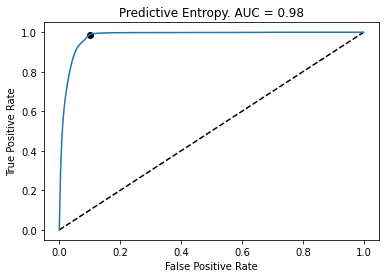

In [104]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [105]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.031025529


In [106]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [107]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(y_pred)
y_pred_thresholded[y_pred >= best_threshold_uncertainty] = 1


In [108]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [109]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [110]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [111]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [112]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [113]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [114]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [120]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, y_pred_val, pos_label=pos_label)



In [121]:
ic(thresholds)

ic| thresholds: array([0.00004428, 0.00004428, 0.00004428, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00004428, 0.00004428, 0.00004428, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [122]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.315346, F-Score=0.410


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_4824\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


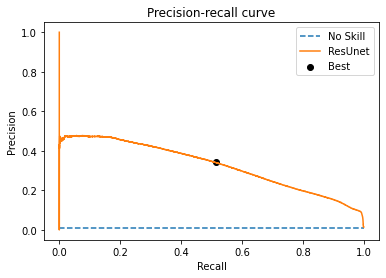

In [123]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [124]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [125]:
ic(np.min(y_pred), np.average(y_pred), np.max(y_pred))

ic| np.min(y_pred): 1.9414037e-18
    np.average(y_pred): 0.012316057
    np.max(y_pred): 0.36787948


(1.9414037e-18, 0.012316057, 0.36787948)

(array([50728023.,   940047.,   537803.,   377425.,   302548.,   257701.,
          233264.,   224835.,   241462.,   409993.]),
 array([0.        , 0.03678795, 0.0735759 , 0.11036384, 0.1471518 ,
        0.18393974, 0.22072768, 0.25751564, 0.2943036 , 0.33109152,
        0.36787948], dtype=float32),
 <BarContainer object of 10 artists>)

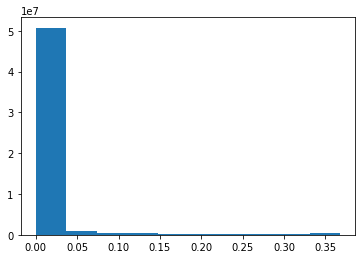

In [126]:
plt.hist(y_pred)

In [127]:
ic(y_pred.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| y_pred.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [128]:
ic(y_pred.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| y_pred.shape: (54253101,)
    label_mask_current_deforestation_test.shape: (54253101,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [167]:
ic(np.min(y_pred), np.mean(y_pred), np.max(y_pred))

ic| np.min(y_pred): 1.9414037e-18
    np.mean(y_pred): 0.012316057
    np.max(y_pred): 0.36787948


(1.9414037e-18, 0.012316057, 0.36787948)

In [129]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(y_pred).astype(np.int8)
predicted_thresholded[y_pred >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54253101,)


(54253101,)

In [130]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([52608654,  1644447], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100946294,   1842066,  60327640], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([52608654,  1644447], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100946294,   1842066,  60327640], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [131]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.030310654500652415


0.030310654500652415

In [132]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(y_pred, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.030310654500652415


0.030310654500652415

In [133]:
importlib.reload(_metrics)

threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metrics_values)



ic| y_pred.shape: (54253101,)
    label_mask_current_deforestation_test.shape: (54253101,)


threshold 0.01
(48812276,) (48812276,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5440825,)
    predicted_test_classified_incorrect.shape: (5440825,)


cm_correct [[48723519        0]
 [   11846    76911]]


ic| TP_H + FN_H + FP_H + TN_H: 5440825
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 5440825
    len(label_mask_current_deforestation_test): 54253101


cm_incorrect [[4676510   86253]
 [ 169981  508081]]
[1.         0.86653447 0.10029877 0.10028597 0.85487453 0.74931348]
threshold 0.015
(49459504,) (49459504,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4793597,)
    predicted_test_classified_incorrect.shape: (4793597,)


cm_correct [[49351998        0]
 [   13555    93951]]


ic| TP_H + FN_H + FP_H + TN_H: 4793597
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 4793597
    len(label_mask_current_deforestation_test): 54253101


cm_incorrect [[4048031   86253]
 [ 168272  491041]]
[1.         0.87391401 0.12252044 0.08835618 0.85059086 0.74477676]
threshold 0.025
(50195715,) (50195715,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4057386,)
    predicted_test_classified_incorrect.shape: (4057386,)


cm_correct [[50064238        0]
 [   15895   115582]]


ic| TP_H + FN_H + FP_H + TN_H: 4057386
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 4057386
    len(label_mask_current_deforestation_test): 54253101


cm_incorrect [[3335791   86253]
 [ 165932  469410]]
[1.         0.87910433 0.15072918 0.07478625 0.84477462 0.73883043]
threshold 0.05
(51146758,) (51146758,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3106343,)
    predicted_test_classified_incorrect.shape: (3106343,)


cm_correct [[50962786       14]
 [   20510   163448]]


ic| TP_H + FN_H + FP_H + TN_H: 3106343
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 3106343
    len(label_mask_current_deforestation_test): 54253101


cm_incorrect [[2437243   86239]
 [ 161317  421544]]
[0.99991435 0.88850716 0.21315069 0.05725651 0.83016564 0.72323247]
threshold 0.08
(51780773,) (51780773,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2472328,)
    predicted_test_classified_incorrect.shape: (2472328,)


cm_correct [[51530999      120]
 [   25538   224116]]


ic| TP_H + FN_H + FP_H + TN_H: 2472328
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 2472328
    len(label_mask_current_deforestation_test): 54253101


cm_incorrect [[1869030   86133]
 [ 156289  360876]]
[0.99946485 0.89770643 0.29226715 0.04557026 0.8073126  0.69779664]
threshold 0.1
(52077473,) (52077473,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2175628,)
    predicted_test_classified_incorrect.shape: (2175628,)


cm_correct [[51786257      352]
 [   28768   262096]]


ic| TP_H + FN_H + FP_H + TN_H: 2175628
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 2175628
    len(label_mask_current_deforestation_test): 54253101


cm_incorrect [[1613772   85901]
 [ 153059  322896]]
[0.99865878 0.90109467 0.34179643 0.04010145 0.78986881 0.67841708]
threshold 0.15
(52608654,) (52608654,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1644447,)
    predicted_test_classified_incorrect.shape: (1644447,)
ic

cm_correct [[52237406     1858]
 [   37090   332300]]
cm_incorrect [[1162623   84395]
 [ 144737  252692]]


| TP_H + FN_H + FP_H + TN_H: 1644447
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 1644447
    len(label_mask_current_deforestation_test): 54253101


[0.99443976 0.89959122 0.43334868 0.03031065 0.74963437 0.63581671]
threshold 0.2
(53002719,) (53002719,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1250382,)
    predicted_test_classified_incorrect.shape: (1250382,)
ic| TP_H + FN_H + FP_H + TN_H: 1250382
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 1250382
    len(label_mask_current_deforestation_test): 54253101


cm_correct [[52556345     6699]
 [   46648   393027]]
cm_incorrect [[843684  79554]
 [135179 191965]]
[0.98324102 0.89390345 0.51254207 0.0230472  0.70700393 0.58679053]
threshold 0.25
(53330351,) (53330351,)


ic| label_current_deforestation_test_classified_incorrect.shape: (922750,)
    predicted_test_classified_incorrect.shape: (922750,)
ic| TP_H + FN_H + FP_H + TN_H: 922750
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 922750
    len(label_mask_current_deforestation_test): 54253101


cm_correct [[52810756    14249]
 [   59636   445710]]
cm_incorrect [[589273  72004]
 [122191 139282]]
[0.96902115 0.88198977 0.58124538 0.01700824 0.65921074 0.53268215]
threshold 0.27
(53452730,) (53452730,)


ic| label_current_deforestation_test_classified_incorrect.shape: (800371,)
    predicted_test_classified_incorrect.shape: (800371,)
ic| TP_H + FN_H + FP_H + TN_H: 800371
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 800371
    len(label_mask_current_deforestation_test): 54253101


cm_correct [[52902019    18190]
 [   66641   465880]]
cm_incorrect [[498010  68063]
 [115186 119112]]
[0.96242279 0.87485752 0.60754885 0.01475254 0.63636704 0.50837822]
threshold 0.3
(53637149,) (53637149,)


ic| label_current_deforestation_test_classified_incorrect.shape: (615952,)
    predicted_test_classified_incorrect.shape: (615952,)
ic| TP_H + FN_H + FP_H + TN_H: 615952
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 615952
    len(label_mask_current_deforestation_test): 54253101


cm_correct [[53032966    26654]
 [   80089   497440]]
cm_incorrect [[367063  59599]
 [101738  87552]]
[0.94914271 0.86132471 0.64870589 0.0113533  0.59498067 0.4625284 ]
threshold 0.34
(53907378,) (53907378,)


ic| label_current_deforestation_test_classified_incorrect.shape: (345723,)
    predicted_test_classified_incorrect.shape: (345723,)
ic| TP_H + FN_H + FP_H + TN_H: 345723
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 345723
    len(label_mask_current_deforestation_test): 54253101


cm_correct [[53208847    47812]
 [  107298   543421]]
cm_incorrect [[191182  38441]
 [ 74529  41571]]
[0.91913171 0.83510855 0.70866919 0.00637241 0.51955957 0.35806202]
threshold 0.36
(54081388,) (54081388,)


ic| label_current_deforestation_test_classified_incorrect.shape: (171713,)
    predicted_test_classified_incorrect.shape: (171713,)
ic| TP_H + FN_H + FP_H + TN_H: 171713
    len(label_mask_current_deforestation_test): 54253101
ic| TP_H + FN_H + FP_H + TN_H: 171713
    len(label_mask_current_deforestation_test): 54253101
ic| metrics_values: array([[1.        , 0.86653447, 0.10029877, 0.10028597, 0.85487453,
                            0.74931348],
                           [1.        , 0.87391401, 0.12252044, 0.08835618, 0.85059086,
                            0.74477676],
                           [1.        , 0.87910433, 0.15072918, 0.07478625, 0.84477462,
                            0.73883043],
                           [0.99991435, 0.88850716, 0.21315069, 0.05725651, 0.83016564,
                            0.72323247],
                           [0.99946485, 0.89770643, 0.29226715, 0.04557026, 0.8073126 ,
                            0.69779664],
                           [0.998

cm_correct [[53301260    73775]
 [  131860   574493]]
cm_incorrect [[98769 12478]
 [49967 10499]]
[0.88619676 0.8133228  0.74918983 0.00316504 0.4569352  0.17363477]


In [134]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(y_pred.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(y_pred, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| y_pred.shape: (54253101,)
    label_mask_current_deforestation_test.shape: (54253101,)


threshold 0.01
(54253101,) (54253101,)
cm_audited [[53486282        0]
 [   11846   754973]]
[1.         0.98455177]
threshold 0.015
(54253101,) (54253101,)
cm_audited [[53486282        0]
 [   13555   753264]]
[1.         0.98232308]
threshold 0.025
(54253101,) (54253101,)
cm_audited [[53486282        0]
 [   15895   750924]]
[1.         0.97927151]
threshold 0.05
(54253101,) (54253101,)
cm_audited [[53486268       14]
 [   20510   746309]]
[0.99998124 0.97325314]
threshold 0.08
(54253101,) (54253101,)
cm_audited [[53486162      120]
 [   25538   741281]]
[0.99983814 0.96669618]
threshold 0.1
(54253101,) (54253101,)
cm_audited [[53485930      352]
 [   28768   738051]]
[0.9995233  0.96248398]
threshold 0.15
(54253101,) (54253101,)
cm_audited [[53484424     1858]
 [   37090   729729]]
[0.99746032 0.95163135]
threshold 0.2
(54253101,) (54253101,)
cm_audited [[53479583     6699]
 [   46648   720171]]
[0.99078377 0.93916687]
threshold 0.25
(54253101,) (54253101,)
cm_audited [[53472033    

ic| metric_values_audited: array([[1.        , 0.98455177],
                                  [1.        , 0.98232308],
                                  [1.        , 0.97927151],
                                  [0.99998124, 0.97325314],
                                  [0.99983814, 0.96669618],
                                  [0.9995233 , 0.96248398],
                                  [0.99746032, 0.95163135],
                                  [0.99078377, 0.93916687],
                                  [0.980249  , 0.92222937],
                                  [0.97467872, 0.91309422],
                                  [0.96263723, 0.89555684],
                                  [0.93240525, 0.86007389],
                                  [0.89590594, 0.82804286]])


cm_audited [[53412507    73775]
 [  131860   634959]]
[0.89590594 0.82804286]


In [135]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [136]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(y_pred,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(y_pred,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [137]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [138]:
save_figures = True

In [139]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}



In [140]:
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [141]:
# m['precision_H'] = np.nan_to_num(m['precision_H'], nan=0)

In [142]:
'''
m = {'precision_L': metrics[1:,0],
        'recall_L': metrics[1:,1],
        'recall_Ltotal': metrics[1:,2],
        'AA': metrics[1:,3],
        'precision_H': metrics[1:,4],
        'recall_H': metrics[1:,5]}

threshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
'''

"\nm = {'precision_L': metrics[1:,0],\n        'recall_L': metrics[1:,1],\n        'recall_Ltotal': metrics[1:,2],\n        'AA': metrics[1:,3],\n        'precision_H': metrics[1:,4],\n        'recall_H': metrics[1:,5]}\n\nthreshold_list = [0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\n"

In [143]:
'''
plt.plot(m['recall_L']*100, m['AA']*100)
plt.title('Recall vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, m['AA']*100)\nplt.title('Recall vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_AA.png', dpi=150, bbox_inches='tight')\n"

In [144]:
'''
plt.plot(m['precision_L']*100, m['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, m['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/precision_AA.png', dpi=150, bbox_inches='tight')\n"

In [145]:
'''
plt.plot(m['recall_Ltotal']*100, m['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if save_figures == True:
    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, m['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif save_figures == True:\n    plt.savefig('figures/recall_total_AA.png', dpi=150, bbox_inches='tight')\n"

In [146]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Recall vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Recall vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

In [147]:
'''
plt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_Ltotal']*100, np.asarray(threshold_list))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [148]:
'''
plt.plot(m['precision_L']*100, np.asarray(threshold_list))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['precision_L']*100, np.asarray(threshold_list))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/precision_total_threshold.png', dpi=150, bbox_inches='tight')\n"

In [149]:
'''
plt.plot(m['recall_L']*100, np.asarray(threshold_list))
plt.title('Audit area vs. Threshold')
plt.xlabel('Audit area (%)')
plt.ylabel('Threshold')
if save_figures == True:
    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m['recall_L']*100, np.asarray(threshold_list))\nplt.title('Audit area vs. Threshold')\nplt.xlabel('Audit area (%)')\nplt.ylabel('Threshold')\nif save_figures == True:\n    plt.savefig('figures/recall_threshold.png', dpi=150, bbox_inches='tight')\n"

In [150]:
m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

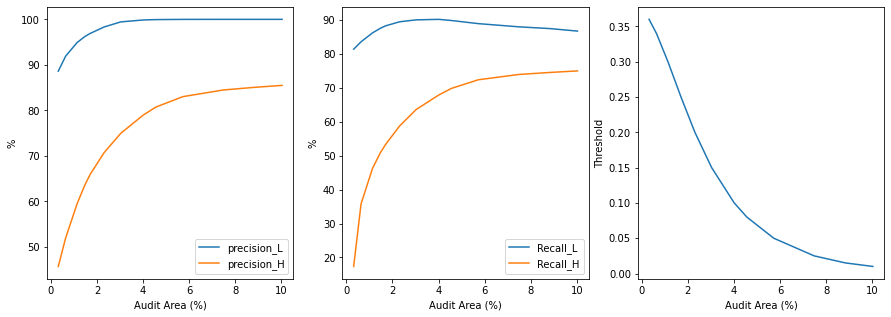

In [151]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [152]:
xlim = [-0.3, 12.7]
ylim = [0, 105]


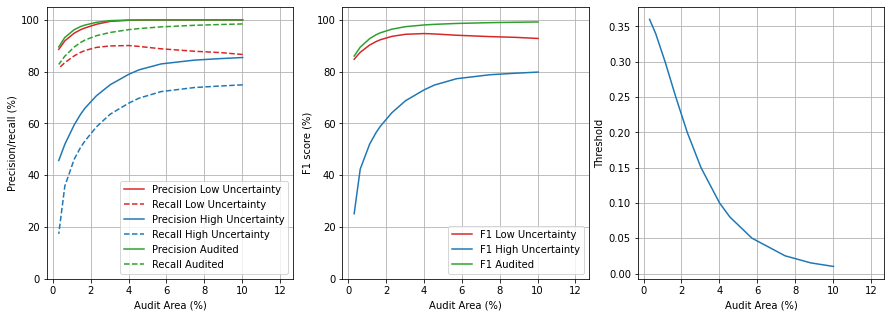

In [153]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [154]:


m

{'precision_L': array([1.        , 1.        , 1.        , 0.99991435, 0.99946485,
        0.99865878, 0.99443976, 0.98324102, 0.96902115, 0.96242279,
        0.94914271, 0.91913171, 0.88619676]),
 'recall_L': array([0.86653447, 0.87391401, 0.87910433, 0.88850716, 0.89770643,
        0.90109467, 0.89959122, 0.89390345, 0.88198977, 0.87485752,
        0.86132471, 0.83510855, 0.8133228 ]),
 'recall_Ltotal': array([0.10029877, 0.12252044, 0.15072918, 0.21315069, 0.29226715,
        0.34179643, 0.43334868, 0.51254207, 0.58124538, 0.60754885,
        0.64870589, 0.70866919, 0.74918983]),
 'AA': array([0.10028597, 0.08835618, 0.07478625, 0.05725651, 0.04557026,
        0.04010145, 0.03031065, 0.0230472 , 0.01700824, 0.01475254,
        0.0113533 , 0.00637241, 0.00316504]),
 'precision_H': array([0.85487453, 0.85059086, 0.84477462, 0.83016564, 0.8073126 ,
        0.78986881, 0.74963437, 0.70700393, 0.65921074, 0.63636704,
        0.59498067, 0.51955957, 0.4569352 ]),
 'recall_H': array([0.749

In [155]:
m_audited

{'precision': array([1.        , 1.        , 1.        , 0.99998124, 0.99983814,
        0.9995233 , 0.99746032, 0.99078377, 0.980249  , 0.97467872,
        0.96263723, 0.93240525, 0.89590594]),
 'recall': array([0.98455177, 0.98232308, 0.97927151, 0.97325314, 0.96669618,
        0.96248398, 0.95163135, 0.93916687, 0.92222937, 0.91309422,
        0.89555684, 0.86007389, 0.82804286]),
 'f1': array([0.99221576, 0.99108272, 0.98952721, 0.98643617, 0.98298789,
        0.98065402, 0.97400704, 0.96428507, 0.95035448, 0.94288194,
        0.92788624, 0.89478019, 0.86063869])}

In [156]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([9182054,  271168], dtype=int64))

In [157]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(y_pred_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(y_pred_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| y_pred_val.shape: (9453222,)
    label_mask_val_valid.shape: (9453222,)


threshold 0.015
(8146253,) (8146253,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1306969,)
    predicted_test_classified_incorrect.shape: (1306969,)
ic| TP_H + FN_H + FP_H + TN_H: 1306969
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 1306969
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8142964       0]
 [    499    2790]]
cm_incorrect [[998554  40536]
 [ 57486 210393]]
[1.         0.84828215 0.01028882 0.13825646 0.8384563  0.78540311]
threshold 0.025
(8339076,) (8339076,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1114146,)
    predicted_test_classified_incorrect.shape: (1114146,)
ic| TP_H + FN_H + FP_H + TN_H: 1114146
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 1114146
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8318256       7]
 [    718   20095]]
cm_incorrect [[823262  40529]
 [ 57267 193088]]
[0.99965178 0.96550233 0.07410535 0.11785886 0.82651519 0.77125682]
threshold 0.05
(8609316,) (8609316,)


ic| label_current_deforestation_test_classified_incorrect.shape: (843906,)
    predicted_test_classified_incorrect.shape: (843906,)
ic| TP_H + FN_H + FP_H + TN_H: 843906
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 843906
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8538816    2835]
 [   1325   66340]]
cm_incorrect [[602702  37701]
 [ 56660 146843]]
[0.95901699 0.98041824 0.24464539 0.08927178 0.79570726 0.72157659]
threshold 0.08
(8781712,) (8781712,)


ic| label_current_deforestation_test_classified_incorrect.shape: (671510,)
    predicted_test_classified_incorrect.shape: (671510,)
ic| TP_H + FN_H + FP_H + TN_H: 671510
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 671510
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8680861    4809]
 [   2253   93789]]
cm_incorrect [[460657  35727]
 [ 55732 119394]]
[0.95122619 0.97654151 0.34587046 0.07103504 0.76968302 0.68176056]
threshold 0.1
(8861922,) (8861922,)


ic| label_current_deforestation_test_classified_incorrect.shape: (591300,)
    predicted_test_classified_incorrect.shape: (591300,)
ic| TP_H + FN_H + FP_H + TN_H: 591300
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 591300
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8746523    6242]
 [   3096  106061]]
cm_incorrect [[394995  34294]
 [ 54889 107122]]
[0.94441823 0.97163718 0.39112653 0.0625501  0.75749562 0.66120202]
threshold 0.15
(9005194,) (9005194,)


ic| label_current_deforestation_test_classified_incorrect.shape: (448028,)
    predicted_test_classified_incorrect.shape: (448028,)
ic| TP_H + FN_H + FP_H + TN_H: 448028
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 448028
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8858610   10555]
 [   5724  130305]]
cm_incorrect [[282908  29981]
 [ 52261  82878]]
[0.92506744 0.95792074 0.48053236 0.04739421 0.73434994 0.61327966]
threshold 0.2
(9112308,) (9112308,)


ic| label_current_deforestation_test_classified_incorrect.shape: (340914,)
    predicted_test_classified_incorrect.shape: (340914,)
ic| TP_H + FN_H + FP_H + TN_H: 340914
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 340914
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8936231   14955]
 [   9168  151954]]
cm_incorrect [[205287  25581]
 [ 48817  61229]]
[0.91040028 0.94309902 0.56036848 0.03606326 0.70532197 0.5563946 ]
threshold 0.25
(9199440,) (9199440,)


ic| label_current_deforestation_test_classified_incorrect.shape: (253782,)
    predicted_test_classified_incorrect.shape: (253782,)
ic| TP_H + FN_H + FP_H + TN_H: 253782
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 253782
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8997408   18817]
 [  13572  169643]]
cm_incorrect [[144110  21719]
 [ 44413  43540]]
[0.90015388 0.9259231  0.6256011  0.02684608 0.66718767 0.49503712]
threshold 0.27
(9231604,) (9231604,)


ic| label_current_deforestation_test_classified_incorrect.shape: (221618,)
    predicted_test_classified_incorrect.shape: (221618,)
ic| TP_H + FN_H + FP_H + TN_H: 221618
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 221618
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9019382   20578]
 [  15641  176003]]
cm_incorrect [[122136  19958]
 [ 42344  37180]]
[0.8953205  0.91838513 0.6490552  0.02344365 0.65070531 0.46753181]
threshold 0.3
(9279602,) (9279602,)


ic| label_current_deforestation_test_classified_incorrect.shape: (173620,)
    predicted_test_classified_incorrect.shape: (173620,)
ic| TP_H + FN_H + FP_H + TN_H: 173620
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 173620
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9051055   23816]
 [  19477  185254]]
cm_incorrect [[90463 16720]
 [38508 27929]]
[0.886086   0.90486541 0.68317058 0.01836622 0.62552353 0.42038322]
threshold 0.34
(9349826,) (9349826,)


ic| label_current_deforestation_test_classified_incorrect.shape: (103396,)
    predicted_test_classified_incorrect.shape: (103396,)
ic| TP_H + FN_H + FP_H + TN_H: 103396
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 103396
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9092044   30533]
 [  28143  199106]]
cm_incorrect [[49474 10003]
 [29842 14077]]
[0.86703914 0.87615787 0.7342533  0.01093765 0.58459302 0.32052187]
threshold 0.36
(9399829,) (9399829,)


ic| label_current_deforestation_test_classified_incorrect.shape: (53393,)
    predicted_test_classified_incorrect.shape: (53393,)
ic| TP_H + FN_H + FP_H + TN_H: 53393
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 53393
    len(label_mask_current_deforestation_test): 9453222
ic| metrics_values_val: array([[1.        , 0.84828215, 0.01028882, 0.13825646, 0.8384563 ,
                                0.78540311],
                               [0.99965178, 0.96550233, 0.07410535, 0.11785886, 0.82651519,
                                0.77125682],
                               [0.95901699, 0.98041824, 0.24464539, 0.08927178, 0.79570726,
                                0.72157659],
                               [0.95122619, 0.97654151, 0.34587046, 0.07103504, 0.76968302,
                                0.68176056],
                               [0.94441823, 0.97163718, 0.39112653, 0.0625501 , 0.75749562,
                                0.66120202],

cm_correct [[9115658   37532]
 [  37322  209317]]
cm_incorrect [[25860  3004]
 [20663  3866]]
[0.84795563 0.84867762 0.77190893 0.00564813 0.56273654 0.15760936]


In [158]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [159]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


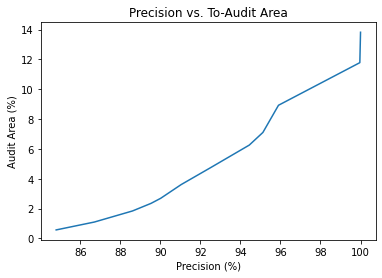

In [160]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

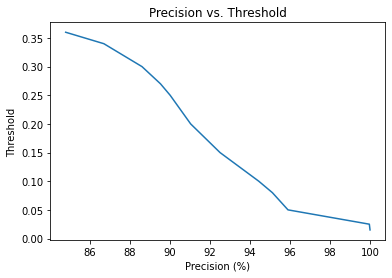

In [161]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

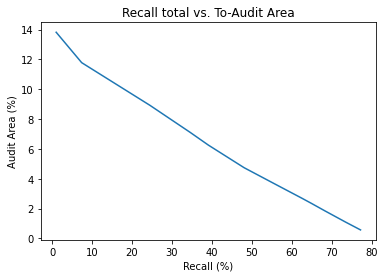

In [162]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

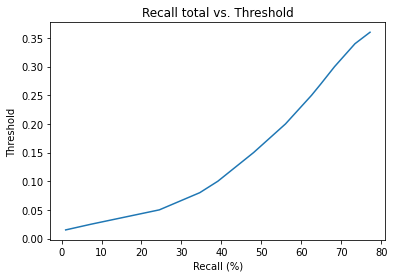

In [163]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

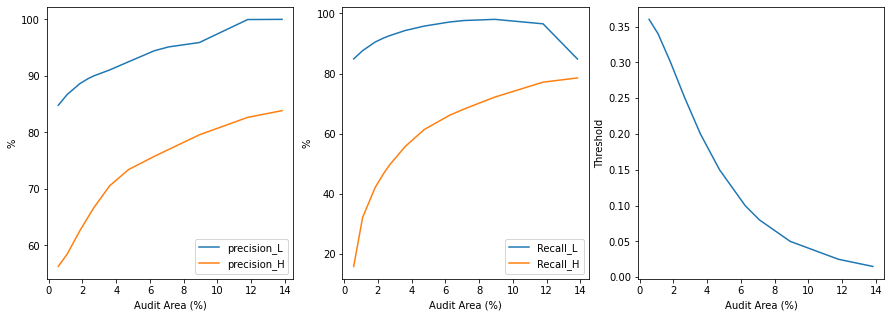

In [164]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

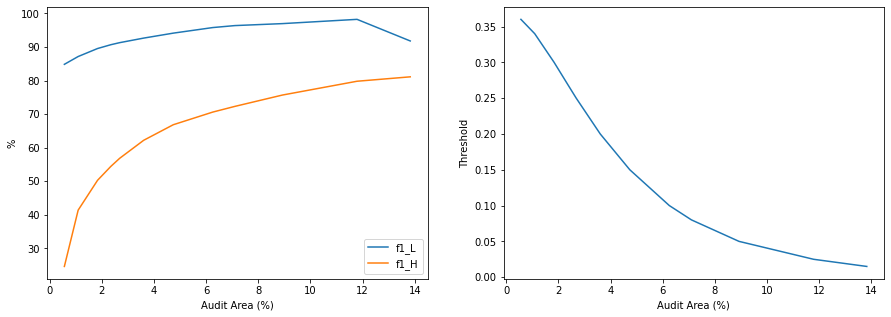

In [165]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

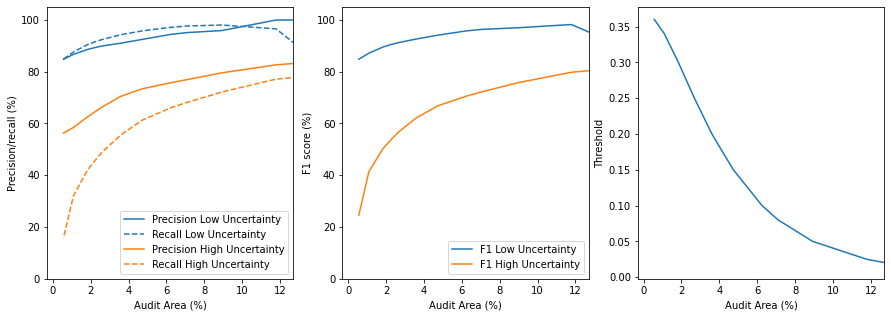

In [166]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')